In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
import math
import time
import functionToOptimise as fun

In [2]:
class myCallback:
    def __init__(self):
        self.mxEvals = []
    def evaluate(self, x, *args):
        self.mxEvals.append(x)

# Dimension 50

In [7]:
f = fun.shiftedAckley
low = -100
high = 100
my_dim = 50

np.random.seed(1236)
x_init = np.random.uniform(low=low, high=high, size=(my_dim))
cback = myCallback()
startTime = time.time()
sol50 = minimize(f, x_init, method='CG', args=(my_dim,), callback = cback.evaluate, 
                options = {'disp':False, 'maxiter':51, 'gtol':1e-20, 'norm': np.inf, 'eps':1e-2})
runTime = time.time() - startTime
print('message: {}'.format(sol50.message))
print('function value: {:.2f}'.format(sol50.fun))
print('true minimum: {}'.format(fun.fbias[5]))
print('number of iterations: {}'.format(sol50.nit))
print('Computational time: {:.2f} s'.format(runTime))

message: Desired error not necessarily achieved due to precision loss.
function value: -120.00
true minimum: -140.0
number of iterations: 8
Computational time: 0.09 s


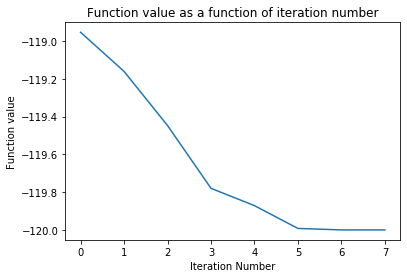

In [4]:
plt.plot([i for i in range(len(cback.mxEvals))], [f(cback.mxEvals[i], my_dim) for i in range(len(cback.mxEvals))])
plt.xlabel('Iteration Number')
plt.ylabel('Function value')
plt.title('Function value as a function of iteration number')
plt.savefig('convergenceCurve_dim_' + str(my_dim))

# Dimension 500

In [5]:
f = fun.shiftedAckley
low = -100
high = 100
my_dim = 500

np.random.seed(1236)
x_init = np.random.uniform(low=low, high=high, size=(my_dim))
cback = myCallback()
startTime = time.time()
sol500 = minimize(f, x_init, method='CG', args=(my_dim,), callback = cback.evaluate, 
                options = {'disp':False, 'maxiter':51, 'gtol':1e-6, 'norm': np.inf, 'eps':1e-2})
runTime = time.time() - startTime
print('message: {}'.format(sol500.message))
print('function value: {:.2f}'.format(sol500.fun))
print('true minimum: {}'.format(fun.fbias[5]))
print('number of iterations: {}'.format(sol500.nit))
print('Computational time: {:.2f} s'.format(runTime))

message: Desired error not necessarily achieved due to precision loss.
function value: -120.00
true minimum: -140.0
number of iterations: 14
Computational time: 1.14 s


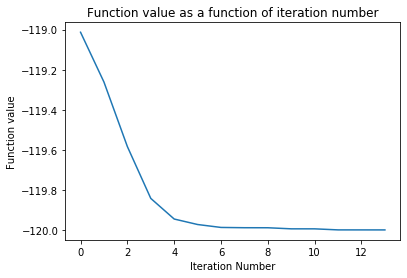

In [6]:
plt.plot([i for i in range(len(cback.mxEvals))], [f(cback.mxEvals[i], my_dim) for i in range(len(cback.mxEvals))])
plt.xlabel('Iteration Number')
plt.ylabel('Function value')
plt.title('Function value as a function of iteration number')
plt.savefig('convergenceCurve_dim_' + str(my_dim))